<a href="https://colab.research.google.com/github/voyager-netizen/Hybrid-anomaly-detection-using-GAN-and-auto-encoders/blob/main/anomaly_detection(gan%2Bauto_encoders).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision numpy pandas matplotlib scikit-learn


Using device: cpu

Training Autoencoder...
Epoch 01 | AE Loss: 0.002050
Epoch 02 | AE Loss: 0.000477
Epoch 03 | AE Loss: 0.000298
Epoch 04 | AE Loss: 0.000211
Epoch 05 | AE Loss: 0.000164
Epoch 06 | AE Loss: 0.000141
Epoch 07 | AE Loss: 0.000119
Epoch 08 | AE Loss: 0.000100
Epoch 09 | AE Loss: 0.000094
Epoch 10 | AE Loss: 0.000089
Epoch 11 | AE Loss: 0.000081
Epoch 12 | AE Loss: 0.000068
Epoch 13 | AE Loss: 0.000060
Epoch 14 | AE Loss: 0.000053
Epoch 15 | AE Loss: 0.000045
Epoch 16 | AE Loss: 0.000041
Epoch 17 | AE Loss: 0.000039
Epoch 18 | AE Loss: 0.000037
Epoch 19 | AE Loss: 0.000036
Epoch 20 | AE Loss: 0.000035

Training GAN...
Epoch 01 | D Loss: 1.354059 | G Loss: 0.733108
Epoch 02 | D Loss: 1.311669 | G Loss: 0.725769
Epoch 03 | D Loss: 1.385988 | G Loss: 0.705653
Epoch 04 | D Loss: 1.384180 | G Loss: 0.693296
Epoch 05 | D Loss: 1.405781 | G Loss: 0.686163
Epoch 06 | D Loss: 1.362470 | G Loss: 0.684056
Epoch 07 | D Loss: 1.378522 | G Loss: 0.701417
Epoch 08 | D Loss: 1.419818 | G

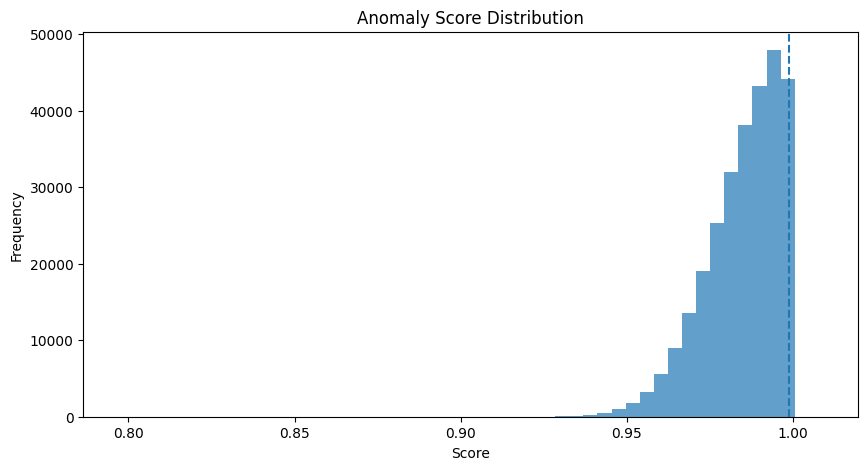

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset


# Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 1. Load & Preprocess Data

df = pd.read_csv("/content/creditcard.csv")

labels = df["Class"].values
df = df.drop(columns=["Class"])

scaler = MinMaxScaler()
data = scaler.fit_transform(df)
data = torch.tensor(data, dtype=torch.float32)

# Use ONLY normal data for training
normal_data = data[labels == 0]

train_loader = DataLoader(
    TensorDataset(normal_data),
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(data),
    batch_size=128,
    shuffle=False
)

input_dim = data.shape[1]


# 2. Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

autoencoder = Autoencoder(input_dim).to(device)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_loss_fn = nn.MSELoss()


# Train Autoencoder

print("\nTraining Autoencoder...")
autoencoder.train()
for epoch in range(20):
    epoch_loss = 0
    for batch, in train_loader:
        batch = batch.to(device)

        ae_optimizer.zero_grad()
        recon, _ = autoencoder(batch)
        loss = ae_loss_fn(recon, batch)
        loss.backward()
        ae_optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | AE Loss: {epoch_loss/len(train_loader):.6f}")


# 3. GAN

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()  # IMPORTANT FIX
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

latent_dim = 32
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
bce = nn.BCELoss()


# Train GAN

print("\nTraining GAN...")
for epoch in range(20):
    for batch, in train_loader:
        batch = batch.to(device)
        batch_size = batch.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        #Train Discriminator
        d_optimizer.zero_grad()

        real_loss = bce(discriminator(batch), real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z).detach()
        fake_loss = bce(discriminator(fake_data), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        #Train Generator
        g_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z)
        g_loss = bce(discriminator(fake_data), real_labels)

        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch {epoch+1:02d} | D Loss: {d_loss.item():.6f} | G Loss: {g_loss.item():.6f}")


# 4. Anomaly Detection

autoencoder.eval()
generator.eval()
discriminator.eval()

anomaly_scores = []

with torch.no_grad():
    for batch, in test_loader:
        batch = batch.to(device)

        recon, _ = autoencoder(batch)
        recon_error = torch.mean((batch - recon) ** 2, dim=1)

        z = torch.randn(batch.size(0), latent_dim).to(device)
        fake_data = generator(z)

        d_real = discriminator(batch).squeeze()
        d_fake = discriminator(fake_data).squeeze()

        score = recon_error + (1 - torch.abs(d_real - d_fake))
        anomaly_scores.extend(score.cpu().numpy())

anomaly_scores = np.array(anomaly_scores)


# 5. Evaluation

threshold = np.percentile(anomaly_scores, 95)
predictions = anomaly_scores > threshold

precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average="binary"
)
auc = roc_auc_score(labels, anomaly_scores)

print("\nEvaluation Results")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"AUC-ROC   : {auc:.4f}")

# 6. Visualization

plt.figure(figsize=(10,5))
plt.hist(anomaly_scores, bins=50, alpha=0.7)
plt.axvline(threshold, linestyle="dashed")
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()